In [222]:
import pandas as pd

df = pd.read_csv("labeledcommentsfinal.csv", encoding="latin1")   



In [223]:
print("Dataset size:", df.shape)

print(df.head())

print(df.tail())

Dataset size: (5556, 2)
                   Comments Label
0  Golden era of ducky bhai   NCA
1           Hi 2025 8.23.??   NCA
2   Who is watching in ²?²?   NCA
3          anyone in 2025??   NCA
4   Who is watching in 2025   NCA
                                               Comments Label
5551  Daniya ya phir yahya ko jeetna chaiyen donu ac...   NCA
5552  Rabail ko reh na chahye final tak wo tw jann h...   NCA
5553           Plzzz rabail ko kbhiii champion na bnana   NCA
5554  Plz rabail ko out kr dein ... aisi lrki ko kbh...   NCA
5555                                        Nikal jahil    CA


In [224]:
print("First 6 rows:")
df.head(6)

First 6 rows:


,Comments,Label
0,Golden era of ducky bhai,NCA
1,Hi 2025 8.23.??,NCA
2,Who is watching in ²?²?,NCA
3,anyone in 2025??,NCA
4,Who is watching in 2025,NCA
5,Who watching in 2025????,NCA


In [225]:
print("last 7 rows:")
df.tail(7)

last 7 rows:


,Comments,Label
5549,Kisi ko nikalo yan na nikalo Yahya ko nikal do,NCA
5550,Rabil ko nakal jana chia ha,NCA
5551,Daniya ya phir yahya ko jeetna chaiyen donu ac...,NCA
5552,Rabail ko reh na chahye final tak wo tw jann h...,NCA
5553,Plzzz rabail ko kbhiii champion na bnana,NCA
5554,Plz rabail ko out kr dein ... aisi lrki ko kbh...,NCA
5555,Nikal jahil,CA


In [226]:
print("Missing values before:", df.isnull().sum().sum())

# Missing rows remove
df = df.dropna()
print("Missing values after:", df.isnull().sum().sum())

Missing values before: 0
Missing values after: 0


In [227]:
# Duplicate rows check and remove
print("Before removing duplicates:", len(df))

df = df.drop_duplicates(subset=["Comments"])
print("After removing duplicates:", len(df))

Before removing duplicates: 5556
After removing duplicates: 5224


In [228]:
print(df.columns)

Index(['Comments', 'Label'], dtype='object')


In [229]:
import re

def clean_text(text):
    text = str(text).lower()                        # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)      # links remove
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)      # emojis/symbols remove
    text = re.sub(r"\s+", " ", text).strip()        # extra spaces remove
    return text

df["Comments"] = df["Comments"].apply(clean_text)

# checking first 10 comments
print(df.head(5))

                   Comments Label
0  golden era of ducky bhai   NCA
1               hi 2025 823   NCA
2        who is watching in   NCA
3            anyone in 2025   NCA
4   who is watching in 2025   NCA


In [230]:
# Comment length 
df["length"] = df["Comments"].apply(len)

# Chhote aur bade comments dikhana (sample)
print("\nShortest comments:")
print(df[df["length"] < 4]["Comments"].head())

print("\nLongest comments:")
print(df[df["length"] > 200]["Comments"].head())



Shortest comments:
16       
34     me
45    wow
46       
47       
Name: Comments, dtype: object

Longest comments:
1553    rabil kisi ka ma baba ko ausa nahi kahta qp ka...
1731    rabail tum na daniya ko q bola jo apny ma bap ...
1766    yr mtlb ye kia h bnda social media zehni sakoo...
1836    yaar plzz show is show you fight in faisal and...
2181    meny ye show dekhna start kia ab lkn jis din r...
Name: Comments, dtype: object


In [231]:
before = len(df)
df = df[(df["length"] >= 4) & (df["length"] <= 200)]
after = len(df)

print("Before removing outliers:", before)
print("After removing outliers:", after)
print("Total removed:", before - after)


Before removing outliers: 5224
After removing outliers: 5023
Total removed: 201


In [232]:
df = df.drop(columns=["length"])


In [233]:
print(df['Label'].value_counts())


Label
NCA     4428
CA       588
 CA        3
 CA        1
 nca       1
 NCA       1
C          1
Name: count, dtype: int64


In [234]:
df['Label'] = df['Label'].str.upper().str.strip()
df = df[df['Label'].map(df['Label'].value_counts()) > 1]
print(df['Label'].value_counts())


Label
NCA    4430
CA      592
Name: count, dtype: int64


In [235]:
df.to_csv("cleaned_comments.csv", index=False, encoding="utf-8-sig")
print("Cleaned dataset saved as cleaned_comments.csv")


Cleaned dataset saved as cleaned_comments.csv


In [269]:
# TF-IDF Feature Extraction

from sklearn.feature_extraction.text import TfidfVectorizer

#Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=2000)  

X_tfidf = tfidf.fit_transform(df['Comments'])  

print("TF-IDF shape:", X_tfidf.shape) 



TF-IDF shape: (5022, 2000)


In [270]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Improved TF-IDF (Fix 5)
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['Comments'])


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['Label'], test_size=0.25, random_state=42, stratify=df['Label']
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 3766
Testing set size: 1256


In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced'),

    # Improved Random Forest 
    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        max_depth=40,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        random_state=42
    ),

    "SVM": SVC(kernel='linear', random_state=42, class_weight='balanced')
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("\n----------------------------------")
    print(f"Model: {name}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")



----------------------------------
Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

          CA       0.38      0.45      0.41       148
         NCA       0.93      0.90      0.91      1108

    accuracy                           0.85      1256
   macro avg       0.65      0.68      0.66      1256
weighted avg       0.86      0.85      0.85      1256

Accuracy: 0.8495

----------------------------------
Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

          CA       0.46      0.35      0.40       148
         NCA       0.92      0.94      0.93      1108

    accuracy                           0.88      1256
   macro avg       0.69      0.65      0.66      1256
weighted avg       0.86      0.88      0.87      1256

Accuracy: 0.8750

----------------------------------
Model: SVM
Classification Report:
              precision    recall  f1-score   support

          CA       0.

In [272]:
print("\n✅ Models dictionary type:", type(models))
print("✅ Models keys:", list(models.keys()))


✅ Models dictionary type: <class 'dict'>
✅ Models keys: ['Logistic Regression', 'Random Forest', 'SVM']


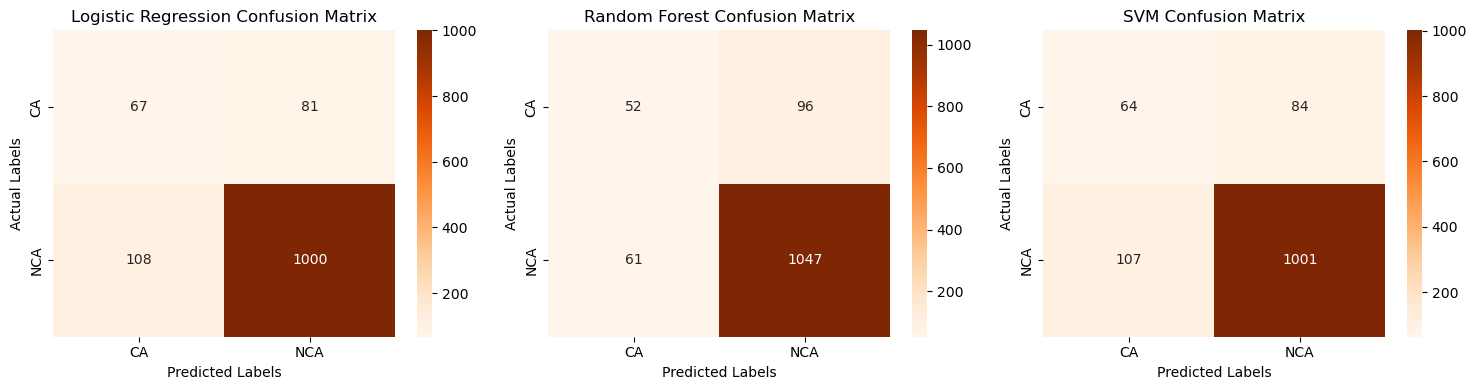

In [273]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,4))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['CA', 'NCA'],
                yticklabels=['CA', 'NCA'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")

plt.tight_layout()
plt.show()


In [274]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)   
    results.append({'Model': name, 'Accuracy': accuracy})

import pandas as pd
results_df = pd.DataFrame(results)  

print(results_df)


                 Model  Accuracy
0  Logistic Regression  0.849522
1        Random Forest  0.875000
2                  SVM  0.847930


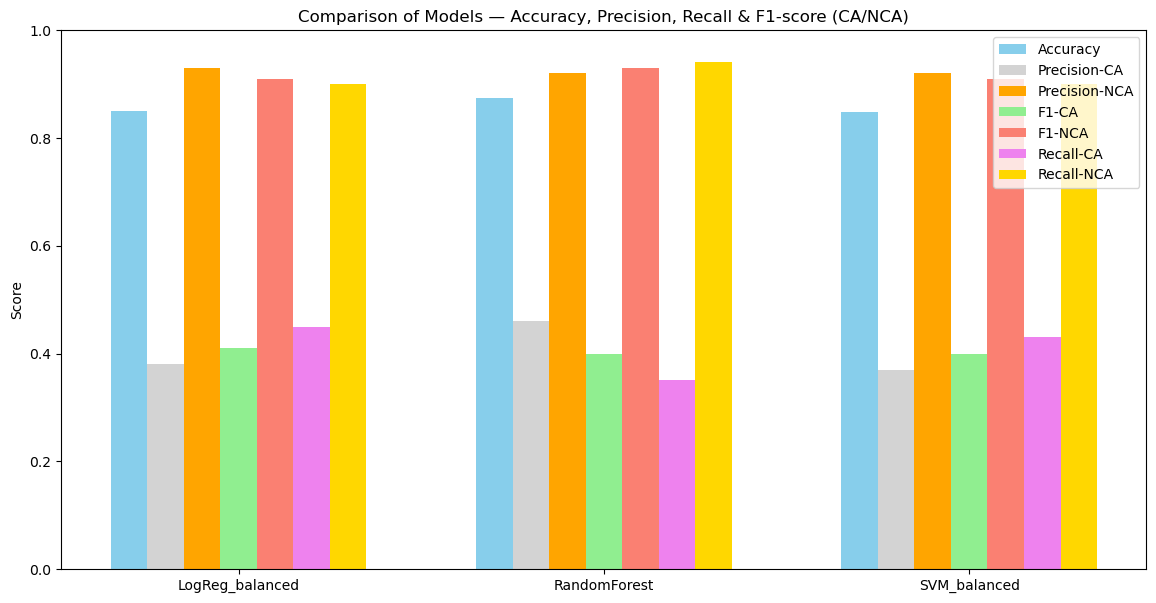

In [275]:
# Cell 7 - Change 'models' to 'model_names'
import matplotlib.pyplot as plt
import numpy as np

# Model names
model_names = ['LogReg_balanced', 'RandomForest', 'SVM_balanced']

# Accuracy
accuracy = [0.8495, 0.8750, 0.8479]

# Precision (CA & NCA)
precision_ca = [0.38, 0.46, 0.37]
precision_nca = [0.93, 0.92, 0.92]

# Recall (CA & NCA)
recall_ca = [0.45, 0.35, 0.43]
recall_nca = [0.90, 0.94, 0.90]

# F1-score (CA & NCA)
f1_ca = [0.41, 0.40, 0.40]
f1_nca = [0.91, 0.93, 0.91]

x = np.arange(len(model_names))  # Changed here too
width = 0.1  

plt.figure(figsize=(14,7))
plt.bar(x - 3*width, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x - 2*width, precision_ca, width, label='Precision-CA', color='lightgray')
plt.bar(x - width, precision_nca, width, label='Precision-NCA', color='orange')
plt.bar(x, f1_ca, width, label='F1-CA', color='lightgreen')
plt.bar(x + width, f1_nca, width, label='F1-NCA', color='salmon')
plt.bar(x + 2*width, recall_ca, width, label='Recall-CA', color='violet')
plt.bar(x + 3*width, recall_nca, width, label='Recall-NCA', color='gold')

plt.xticks(x, model_names)  # Changed here too
plt.ylabel('Score')
plt.title('Comparison of Models — Accuracy, Precision, Recall & F1-score (CA/NCA)')
plt.ylim(0,1)
plt.legend()
plt.show()

In [276]:
logreg_model = models["Logistic Regression"]
rf_model = models["Random Forest"]
svm_model = models["SVM"]

test_comment = "harami"
test_vector = tfidf.transform([test_comment])

logistic_pred = logreg_model.predict(test_vector)[0]
rf_pred = rf_model.predict(test_vector)[0]
svm_pred = svm_model.predict(test_vector)[0]

print("\nPredictions for comment:", test_comment)
print("Logistic Regression:", logistic_pred)
print("Random Forest      :", rf_pred)
print("SVM                :", svm_pred)


Predictions for comment: harami
Logistic Regression: CA
Random Forest      : CA
SVM                : CA


In [277]:
import pickle

# Save TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("TF-IDF vectorizer saved!")



TF-IDF vectorizer saved!


In [278]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        max_depth=40,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        random_state=42
    ),
    "SVM": SVC(kernel='linear', random_state=42, class_weight='balanced')
}

# Train all models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f" {name} trained!")

 Logistic Regression trained!
 Random Forest trained!
 SVM trained!


In [279]:
import pickle

# Save Logistic Regression
with open('logreg_model.pkl', 'wb') as f:
    pickle.dump(models['Logistic Regression'], f)

# Save Random Forest
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(models['Random Forest'], f)

# Save SVM
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(models['SVM'], f)

print("All three models saved successfully!")

All three models saved successfully!
